In [1]:
# Importing libraries
from copy import deepcopy
import random


# Math Libraries
import random
import math
import numpy as np

# Data Processing
import pandas as pd

# Libraries for data visualization
import matplotlib.pyplot as plt  
import seaborn as sns 
from sympy import var, plot_implicit

# ML
from sklearn.linear_model import LogisticRegression # Importing Logistic Model
from sklearn.model_selection import train_test_split # Train Test Split
from sklearn.preprocessing import MinMaxScaler # Data normalizer Min Max Scale
from sklearn.metrics import accuracy_score, mean_squared_error # Calculate the accuracy

# Loading Bar
from time import sleep
from tqdm import tqdm

# Convex Hull
from scipy.spatial import ConvexHull, convex_hull_plot_2d, Delaunay
from numpy.linalg import det
from scipy.stats import dirichlet
from scipy.spatial.distance import euclidean


# Supress warnings
import warnings; warnings.simplefilter('ignore')

In [2]:
def get_eccentricity_2d(points):
    small_latwise = np.min(points[points[:, 0] == np.min(points[:, 0])], 0)
    small_lonwise = np.min(points[points[:, 1] == np.min(points[:, 1])], 0)
    big_latwise = np.max(points[points[:, 0] == np.max(points[:, 0])], 0)
    big_lonwise = np.max(points[points[:, 1] == np.max(points[:, 1])], 0)
    distance_lat = euclidean(big_latwise, small_latwise)
    distance_lon = euclidean(big_lonwise, small_lonwise)
    if distance_lat >= distance_lon:
        major_axis_length = distance_lat
        minor_axis_length = distance_lon
    else:
        major_axis_length = distance_lon
        minor_axis_length = distance_lat
    a = major_axis_length/2
    b = minor_axis_length/2
    ecc = np.sqrt(np.square(a)-np.square(b))/a
    return ecc

## Loading Dataset

In [3]:
# Loading Dataset
adult_folder = pd.read_csv('adult.csv') # Loading Adult

In [4]:
def Adult_Data_Clean(df: pd.DataFrame) -> pd.DataFrame:
  # Changing collumn names for convenience
  df.rename(columns={'capital-gain': 'gain', 'capital-loss': 'loss', 'native-country': 'country',
                    'hours-per-week': 'hours','marital-status': 'marital'}, inplace=True)
  
  # Finding not known data
  df['country'] = df['country'].replace('?',np.nan)
  df['workclass'] = df['workclass'].replace('?',np.nan)
  df['occupation'] = df['occupation'].replace('?',np.nan)
  
  # Dropping not known data
  df.dropna(how='any',inplace=True)

  # Normalizing numerical features
  numerical = ['age', 'fnlwgt', 'educational-num', 'gain', 'loss', 'hours']
  scaler = MinMaxScaler()
  df[numerical] = scaler.fit_transform(df[numerical])  
  return df

In [5]:
adult_dataset = Adult_Data_Clean(adult_folder)

# Separating label (income) from the rest of the data and making income binary
income_raw = adult_dataset['income'].tolist()
adult_dataset = adult_dataset.drop(['income'], axis=1)
income = pd.Series(income_raw).astype('category').cat.codes.tolist()
adult_dataset.drop(adult_dataset.columns.difference(['age', 'educational-num']), 1, inplace=True)
adult_dataset

,age,educational-num
0,0.109589,0.400000
1,0.287671,0.533333
2,0.150685,0.733333
3,0.369863,0.600000
5,0.232877,0.333333
...,...,...
48837,0.136986,0.733333
48838,0.315068,0.533333
48839,0.561644,0.533333
48840,0.068493,0.533333


In [6]:
# One-Hot encoding
per_adult_encoded = pd.get_dummies(adult_dataset)
per_adult_encoded

,age,educational-num
0,0.109589,0.400000
1,0.287671,0.533333
2,0.150685,0.733333
3,0.369863,0.600000
5,0.232877,0.333333
...,...,...
48837,0.136986,0.733333
48838,0.315068,0.533333
48839,0.561644,0.533333
48840,0.068493,0.533333


In [7]:
# Spliting dataset
X_train, X_test, Y_train, Y_test = train_test_split(per_adult_encoded, income, test_size = 0.5, random_state = 0)

## Training Logistic regression

In [8]:
# Trining the Logistic regression classifier
logistic = LogisticRegression(solver = 'liblinear')
logistic.fit(X_train, Y_train)

#Predicting
y_test_pred = logistic.predict(X_test)
y_train_pred = logistic.predict(X_train)

In [9]:
def test(model, qtd_data):
    #Predicting
    y_test_pred = model.predict(X_test[0:qtd_data])
    #y_train_pred = model.predict(X_train)

    # Getting accuracy for the personalized classifier
    #per_train_acc = accuracy_score(Y_train, y_train_pred)
    #per_test_acc = accuracy_score(Y_test[0:qtd_data], y_test_pred)
    
    # L2 score
    #l2_train_acc = mean_squared_error(Y_train, y_train_pred)
    l2_test_acc = mean_squared_error(Y_test[0:qtd_data], y_test_pred)
    
    return l2_test_acc

In [10]:
def multiplicity(m1, m2):
    y_test_pred_1 = m1.predict(X_test)
    y_test_pred_2 = m2.predict(X_test)
    
    return np.mean(np.abs(y_test_pred_1 - y_test_pred_2))

In [11]:
def load_model(mw, pivot):
    model = LogisticRegression(solver = 'liblinear')
    model.coef_ = mw
    model.intercept_ = pivot.intercept_
    model.classes_ = pivot.classes_
    return model

In [12]:
# Getting accuracy for the classifier
performance = test(logistic, -1)
coef = logistic.coef_
performance

0.2237063246351172

In [13]:
delta = .005
Z = np.random.normal(loc=0.0, scale=1.0, size=coef.size)
Z = Z/np.linalg.norm(Z)
cc = coef + delta * Z

In [14]:
center = logistic.coef_
delta = .01 #Size of initial noise
step = 0.1 #step size for each step in an direction
samples = 50 #number of directions
epsilon = 0.01 #Rashomon set size

extremes = np.zeros((samples, coef.size))
early_stopping_exploration = 200
for i in tqdm(range(samples)):
    #Generationg direction
    Z = np.random.normal(loc=0.0, scale=1.0, size=coef.size)
    Z = Z/np.linalg.norm(Z)
    direction = center + delta * Z
    
    #loading model
    lg = load_model(direction, logistic)
    ct = 0
    while (test(lg, -1) - test(logistic, -1)) < epsilon:
        #print(direction, center)
        extremes[i, :] = direction
        dc = center + ct*delta*Z
        lg = load_model(dc, logistic)
        
        ct +=1
        if ct==early_stopping_exploration:
            print(ct)
            break

 28%|████████████                               | 14/50 [00:06<00:25,  1.39it/s]

200


 54%|███████████████████████▏                   | 27/50 [00:12<00:10,  2.11it/s]


KeyboardInterrupt: 

## Sampling from the Rashonmon set

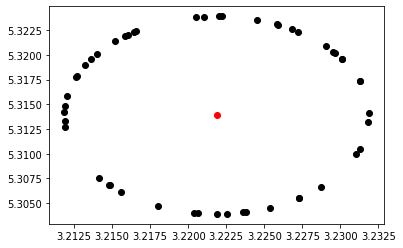

In [1035]:
plt.plot(extremes[:, 0], extremes[:, 1], 'o', color='black');
plt.plot(center[:, 0], center[:, 1], 'o', color='red');

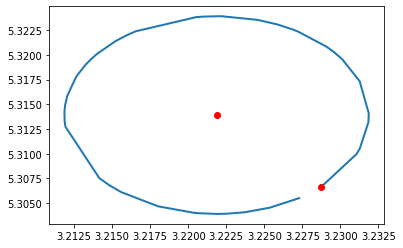

In [1036]:
#Getting convex hull of points
hull = ConvexHull(extremes)

# PLotting
plt.plot(extremes[hull.vertices,0], extremes[hull.vertices,1], lw=2)
plt.plot(extremes[hull.vertices[0],0], extremes[hull.vertices[0],1], 'ro')
plt.plot(center[:, 0], center[:, 1], 'o', color='red');
plt.show()

In [15]:
# Sampling from Rashomon set

def samp_in_hull(points, n):
    dims = points.shape[-1] #get dim
    hull = points[ConvexHull(points).vertices] #get hull
    deln = hull[Delaunay(hull).simplices] #get Delunay

    vols = np.abs(det(deln[:, :dims, :] - deln[:, dims:, :])) / np.math.factorial(dims) #get areas
    sample = np.random.choice(len(vols), size = n, p = vols / vols.sum()) 

    return np.einsum('ijk, ij -> ik', deln[sample], dirichlet.rvs([1]*(dims + 1), size = n))



In [16]:
def ef_samp_in_hull(points, n):
    dim_par = points.shape[0]
    par = np.random.exponential(scale=1.0, size = (n, dim_par))
    normal =  np.sum(par, axis = 1)[:,None] 
    par = par / normal
    
    for i in range(n):
        if np.random.rand() < 1/2:
            idx_1 = np.random.randint(n)
            idx_2 = np.random.randint(dim_par)
            weight = np.random.rand()
            par[idx_1, :] = (1 - weight) * (par[idx_1, :])/(1 - par[idx_1, idx_2])
            par[idx_1, idx_2] = weight

    samples = par @ points
    
    
    return samples

In [17]:
def triangle_sampling(points, n):
    samples = np.zeros((n, points.shape[0]))
    
    for i in range(n):
        idxs = random.sample(range(points.shape[0]), 3)
        
        print(idxs)
    return samples

In [18]:
plt.plot(extremes[hull.vertices,0], extremes[hull.vertices,1], lw=2)
plt.plot(extremes[hull.vertices[0],0], extremes[hull.vertices[0],1], 'ro')
points = samp_in_hull(extremes, 2000)
plt.plot(points[:, 0], points[:, 1], 'o', color='black'); 
plt.plot(center[:, 0], center[:, 1], 'o', color='red');
plt.show()

NameError: name 'hull' is not defined

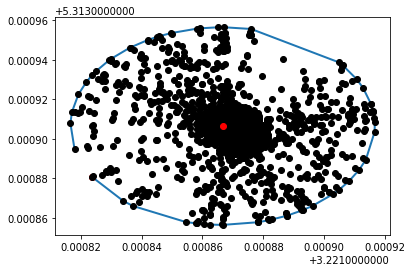

In [24]:
plt.plot(extremes[hull.vertices,0], extremes[hull.vertices,1], lw=2)
plt.plot(extremes[hull.vertices[0],0], extremes[hull.vertices[0],1], 'ro')
plt.plot(extremes[:, 0], extremes[:, 1], 'o', color='black');
points = ef_samp_in_hull(extremes, 2000)
plt.plot(points[:, 0], points[:, 1], 'o', color='black'); 
plt.plot(center[:, 0], center[:, 1], 'o', color='red');
# plt.show()

## Training Linear

In [19]:
from sklearn import linear_model

#loading svm
alpha = 0
plin = linear_model.Ridge(alpha=alpha)

plin.fit(X_train, Y_train)

Ridge(alpha=0)

In [20]:
def get_theoretical_Rashomon(X_t, center, w, alpha, epsilon):
    X = X_t.to_numpy()
    Id = np.identity(X.shape[1])
    A = (X.T @ X + alpha*Id)/epsilon
    v = center - w
    a = (v @ A) @ v.T - 1
    return a

In [21]:
def ridge_load_model(mw, pivot):
    model = deepcopy(pivot)
    model.coef_ = mw
    return model

In [22]:
center = plin.coef_
delta = 0.005 #Size of initial noise
step = 0.01 #step size for each step in an direction
samples = 100 #number of directions
epsilon = 0.01 #Rashomon set size

extremes_l = np.zeros((samples, center.size))
early_stopping_exploration = 100
for i in tqdm(range(samples)):
    #Generationg direction
    Z = np.random.normal(loc=0.0, scale=1.0, size=center.size)
    Z = Z/np.linalg.norm(Z)
    direction = center + delta * Z
    #loading model
    lg = ridge_load_model(direction, plin)
    ct = 0
    while (test(lg, -1) - test(plin, -1)) < epsilon:
        extremes_l[i, :] = direction
        direction =  center + ct*delta*Z
        lg = ridge_load_model(direction, plin)        
        ct +=1
        if ct==early_stopping_exploration:
            break
    

100%|█████████████████████████████████████████| 100/100 [00:23<00:00,  4.31it/s]


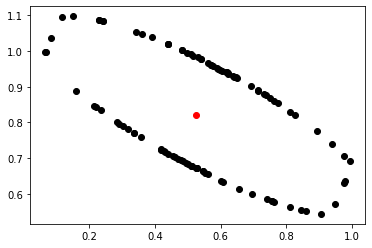

In [23]:
plt.plot(extremes_l[:, 0], extremes_l[:, 1], 'o', color='black');
plt.plot(center[0], center[1], 'o', color='red');

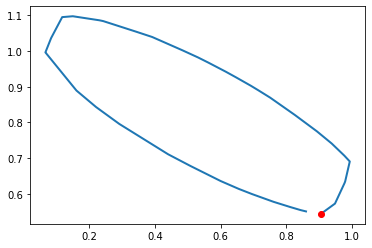

In [25]:
#Getting convex hull of points
hull = ConvexHull(extremes_l)

# PLotting
plt.plot(extremes_l[hull.vertices,0], extremes_l[hull.vertices,1], lw=2)
plt.plot(extremes_l[hull.vertices[0],0], extremes_l[hull.vertices[0],1], 'ro')
plt.show()

In [26]:
# generate grid
step = 100
x_min = np.min(extremes_l[:, 0])
x_max = np.max(extremes_l[:, 0])
y_min = np.min(extremes_l[:, 1])
y_max = np.max(extremes_l[:, 1])
u = np.linspace(x_min,x_max,step)
v = np.linspace(y_min,y_max,step)
par_1, par_2 = np.meshgrid(u, v)

In [27]:
# Computing functionvalue in the grid
value = np.zeros((step, step))
for i in range(step):
    for j in range(step):
        value[i, j] = get_theoretical_Rashomon(X_train,  center, np.array([par_1[i,j], par_2[i,j]]), alpha, epsilon)

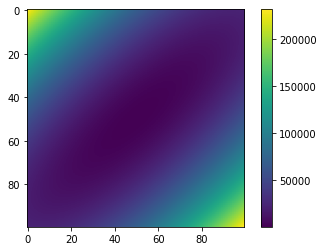

In [28]:
#ploting
plt.contour(par_1, par_2, value, [0])
# plt.plot(extremes_l[hull.vertices,0], extremes_l[hull.vertices,1], lw=2)
# plt.plot(center[0], center[1], 'o', color='red');
plt.imshow(value)
plt.colorbar()

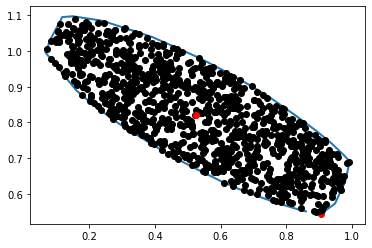

In [29]:
plt.plot(extremes_l[hull.vertices,0], extremes_l[hull.vertices,1], lw=2)
plt.plot(extremes_l[hull.vertices[0],0], extremes_l[hull.vertices[0],1], 'ro')
points = samp_in_hull(extremes_l, 1000)
plt.plot(points[:, 0], points[:, 1], 'o', color='black'); 
plt.plot(center[0], center[1], 'o', color='red');
plt.show()

## Implementing my own Ridge Regression

In [30]:
def get_ridge(X, Y, alpha):
    return np.linalg.inv(X.T@X + alpha*np.identity(X.shape[1])) @ X.T @ Y

def get_ridge_prediction(parameter, X):
    return X@parameter

def get_ridge_l2_loss(parameter, alpha, X, Y):
    fp = Y - X@parameter
    n = X.shape[0]
    return (np.dot(fp, fp) + alpha * np.dot(parameter, parameter) )

In [31]:
np_X = X_train.to_numpy()
omega_hat = get_ridge(np_X, Y_train, alpha)
pred = get_ridge_prediction(omega_hat, np_X)
get_ridge_l2_loss(omega_hat, alpha, np_X, Y_train)
get_ridge_l2_loss(omega_hat + 0.001*np.random.normal(loc=0.0, scale=1.0, size=center.size), alpha, np_X, Y_train) - get_ridge_l2_loss(omega_hat, alpha, np_X, Y_train)

0.027928477645218663

## Experiment above with my own Ridge

In [32]:
center = omega_hat
delta = 0.0001 #Size of initial noise
step = 0.0001 #step size for each step in an direction
samples = 100 #number of directions
epsilon = 1*10**(-1) #Rashomon set size

extremes_l = np.zeros((samples, center.size))
early_stopping_exploration = 1000
for i in tqdm(range(samples)):
    #Generationg direction
    Z = np.random.normal(loc=0.0, scale=1.0, size=center.size)
    Z = Z/np.linalg.norm(Z)
    direction = center + delta * Z
    #loading model
    ct = 1
    while (get_ridge_l2_loss(direction, alpha, np_X, Y_train) - get_ridge_l2_loss(omega_hat, alpha, np_X, Y_train)) < epsilon:
        extremes_l[i, :] = direction
        direction = center + ct*delta*Z
        ct += 1
        if ct==early_stopping_exploration:
            break

100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.47it/s]


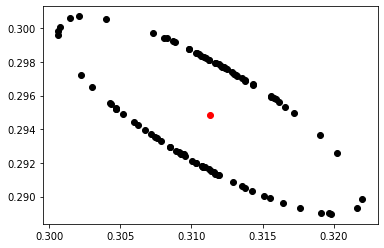

In [33]:
plt.plot(extremes_l[:, 0], extremes_l[:, 1], 'o', color='black');
plt.plot(center[0], center[1], 'o', color='red');

In [34]:
# generate grid
step = 100
x_min = np.min(extremes_l[:, 0]) - 0.001
x_max = np.max(extremes_l[:, 0]) + 0.001
y_min = np.min(extremes_l[:, 1]) - 0.001
y_max = np.max(extremes_l[:, 1]) + 0.001
u = np.linspace(x_min,x_max,step)
v = np.linspace(y_min,y_max,step)
par_1, par_2 = np.meshgrid(u, v)

In [35]:
# Computing functionvalue in the grid
value = np.zeros((step, step))
for i in range(step):
    for j in range(step):
        value[i, j] = get_theoretical_Rashomon(X_train,  center, np.array([par_1[i,j], par_2[i,j]]), alpha, epsilon)

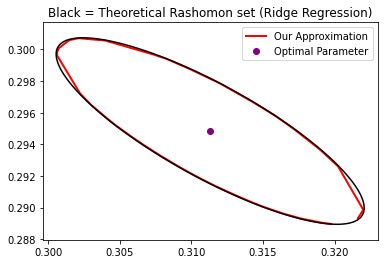

In [45]:
#Getting convex hull of points
hull = ConvexHull(extremes_l)

# PLotting
plt.plot(extremes_l[hull.vertices,0], extremes_l[hull.vertices,1], lw=2, color = 'red',label = 'Our Approximation')
#plt.plot(extremes_l[:, 0], extremes_l[:, 1], 'o', color = 'gray', lw = .1, label = 'Sampled points')
plt.plot(center[0], center[1], 'o', color = 'purple', label = 'Optimal Parameter')
plt.contour(par_1, par_2, value, [0], cmap=plt.get_cmap('hot'))
plt.title('Black = Theoretical Rashomon set (Ridge Regression)')
plt.savefig('Rashomon_ridge_set.pdf')
plt.legend()

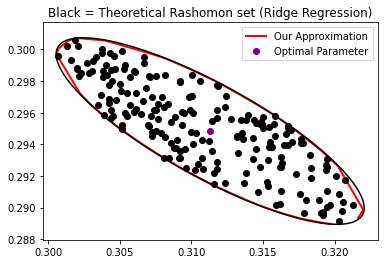

In [54]:
points = samp_in_hull(extremes_l, 200)

# PLotting
plt.plot(extremes_l[hull.vertices,0], extremes_l[hull.vertices,1], lw=2, color = 'red',label = 'Our Approximation')
#plt.plot(extremes_l[:, 0], extremes_l[:, 1], 'o', color = 'gray', lw = .1, label = 'Sampled points')
plt.contour(par_1, par_2, value, [0], cmap=plt.get_cmap('hot'))
plt.title('Black = Theoretical Rashomon set (Ridge Regression)')
plt.plot(points[:, 0], points[:, 1], 'o', color='black', lw = '1'); 
plt.plot(center[0], center[1], 'o', color = 'purple', label = 'Optimal Parameter')
plt.legend()

plt.savefig('Rashomon_logistic_samples.pdf')

